In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import os.path
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 12]

URL_BASE = "https://data.ontario.ca"
URL_TEST_DATA_PAGE = "/dataset/status-of-covid-19-cases-in-ontario"
URL_CSV_SUFFIX = "/download/covidtesting.csv"
GOV_TEST_DATA_TITLE = "Status of COVID-19 cases in Ontario"

FOLDER_TEST_DATA = "data"

# Get and clean case data

In [2]:
def scrape_test_data_url(url_website):
    """
    Return the URL of today's COVID data from data.ontario.ca.
    
    Parameters
    ==========
    url_website: str
        URL of the public-facing website of the Government of Ontario's Data Catalog on COVID.
        Title: "Status of COVID-19 cases in Ontario"
        
    Return
    ======
    url_test_data: str
        URL of the CSV of today's COVID data.
    """
    response = requests.get(url_website, headers={"User-Agent": "Requests"})
    soup = BeautifulSoup(response.text, "html.parser")
    url_test_resource = soup.find("a", title=GOV_TEST_DATA_TITLE)["href"]
    url_test_data = "".join([URL_BASE, url_test_resource, URL_CSV_SUFFIX])
    return url_test_data

In [3]:
def fetch_test_data(url_test_data):
    """
    Get and save today's Ontario COVID data.
    
    Parameters
    ==========
    url_test_data: str
        URL to the CSV of today's COVID data.
    
    Return
    ======
    filename_test_data: str
        Local path to the CSV file containing the COVID data.
    """
    http_response = requests.get(url_test_data)
    date_iso = pd.to_datetime('now').strftime("%Y-%m-%d")
    filename_test_data = f"{os.path.join(FOLDER_TEST_DATA, date_iso)}.csv"
    with open(filename_test_data, "wb") as f:
        f.write(http_response.content)
    return filename_test_data

In [4]:
def load_test_data(filename_test_data):
    """
    Load case data into memory.
    
    Parameters
    ==========
    filename_test_data: str
        Path to the CSV file containing the COVID data.
    
    Return
    ======
    tests: DataFrame
        The COVID case count data.
    """
    with open(filename_test_data, "rb") as f:
        tests = pd.read_csv(f)
    return tests

In [5]:
def clean_test_data(tests):
    """
    Clean the case data.
    
    Parameters
    ==========
    tests: DataFrame
        The COVID case count data.
        
    Return
    ======
    tests_cleaned: DataFrame
        The COVID case count data, cleaned.
    """
    df = tests.copy()
    df = df.set_index("Reported Date")
    df.index = pd.to_datetime(df.index)
    df = df.fillna(0)
    df = df.astype(int)
    tests_cleaned = df
    return tests_cleaned

In [6]:
url_website = "".join([URL_BASE, URL_TEST_DATA_PAGE])
# Get the URL of the case data CSV on the Ontario Government website
url_test_data = scrape_test_data_url(url_website)
# Download the CSV of the case data CSV
filename_test_data = fetch_test_data(url_test_data)
test_data = load_test_data(filename_test_data)
# Clean the case data and return a DataFrame
tests = clean_test_data(test_data)

In [7]:
tests.tail()

,Confirmed Negative,Presumptive Negative,Under Investigation,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total patients approved for testing as of Reporting Date,Total Cases,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19
Reported Date,,,,,,,,,,,,
2020-04-09,0,0,1208,0,3254,2305,200,88698,5759,632,264,214
2020-04-10,0,0,1598,0,3441,2574,222,92673,6237,673,260,217
2020-04-11,0,0,1517,0,3537,2858,253,96321,6648,691,257,215
2020-04-12,0,0,1619,0,3654,3121,274,103165,7049,738,261,196
2020-04-13,0,0,1534,0,3822,3357,291,108230,7470,760,263,203


In [9]:
d_tests = tests - tests.shift(1)
d_tests.tail()

,Confirmed Negative,Presumptive Negative,Under Investigation,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total patients approved for testing as of Reporting Date,Total Cases,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19
Reported Date,,,,,,,,,,,,
2020-04-09,0.0,0.0,106.0,0.0,226.0,231.0,26.0,4097.0,483.0,27.0,18.0,19.0
2020-04-10,0.0,0.0,390.0,0.0,187.0,269.0,22.0,3975.0,478.0,41.0,-4.0,3.0
2020-04-11,0.0,0.0,-81.0,0.0,96.0,284.0,31.0,3648.0,411.0,18.0,-3.0,-2.0
2020-04-12,0.0,0.0,102.0,0.0,117.0,263.0,21.0,6844.0,401.0,47.0,4.0,-19.0
2020-04-13,0.0,0.0,-85.0,0.0,168.0,236.0,17.0,5065.0,421.0,22.0,2.0,7.0


### Do counts from past dates change in new versions of the dataset?

In [10]:
tests_today = tests

In [11]:
with open("data/2020-04-12.csv", "r") as f:
    tests_past = pd.read_csv(f)
tests_past = clean_test_data(tests_past)

In [12]:
tests_diff = tests_today - tests_past
tests_diff.tail(7)

,Confirmed Negative,Presumptive Negative,Under Investigation,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total patients approved for testing as of Reporting Date,Total Cases,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19
Reported Date,,,,,,,,,,,,
2020-04-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


They don't appear to! Aside from missing the most current date

# Plot: fractional change in active cases over time

In [13]:
metrics = pd.DataFrame()

In [ ]:
# Outstanding cases are confirmed positives that have not ended in: deaths, resolved

In [14]:
metrics["outstanding"] = tests["Confirmed Positive"] - tests["Deaths"] - tests["Resolved"]

In [15]:
metrics["d_outstanding"] = metrics["outstanding"]/metrics["outstanding"].shift(1)

In [16]:
government_interventions = [
    {
        "date": "2020-03-17", 
        "action": "State of emergency"
    }, 
    #    {
    #    "date": "2020-03-20", 
    #    "action": "US border closed"
    #}, 
        {
        "date": "2020-03-24", 
        "action": "Non-essential\nbusinesses closed"
    }, 
            {
        "date": "2020-04-03", 
        "action": "Non-essential\nbusiness list\nbroadened"
    }, 
]

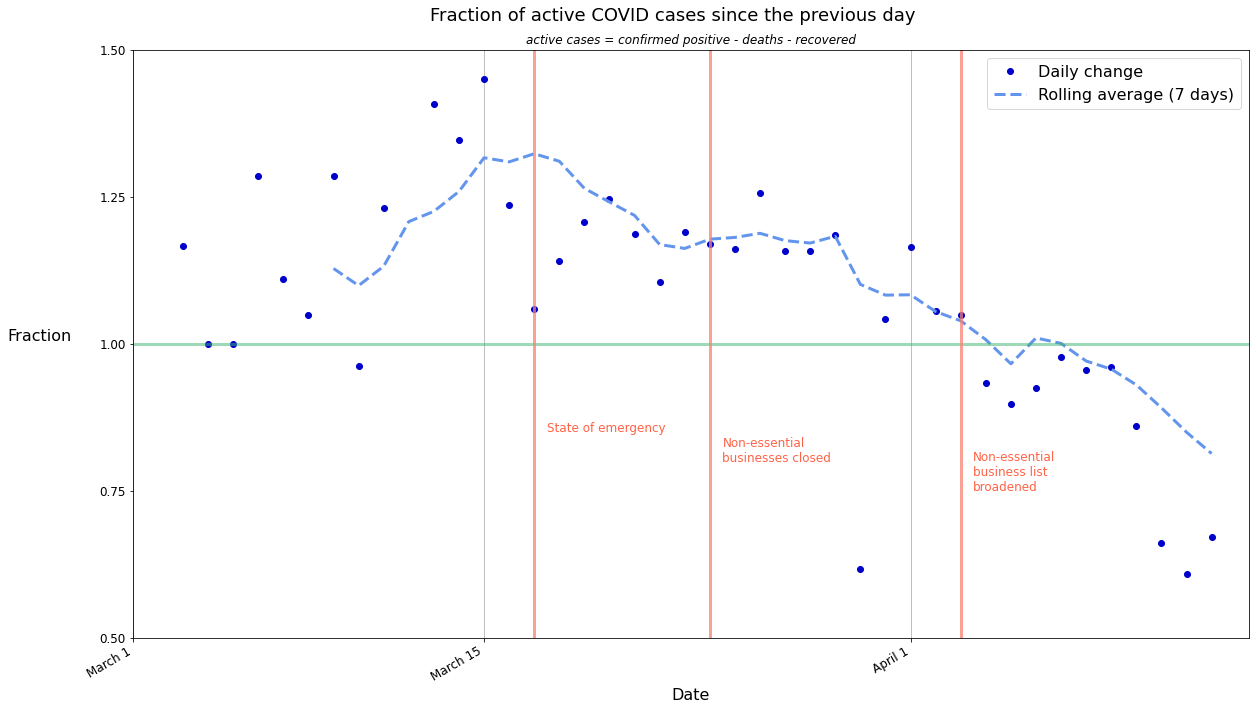

In [17]:
df = metrics
x = df.index
y = df["d_outstanding"]
y_avg = y.rolling(7).mean()

fig, ax = plt.subplots()

ax.plot(x, y, "o",
        color="mediumblue",
        label="Daily change")
ax.plot(x, y_avg, "--", 
        color="cornflowerblue",
        linewidth=3,
        label="Rolling average (7 days)")
ax.axhline(1, 
           color="mediumseagreen",
           alpha=0.5,
          linewidth=3)

small_font = 12
medium_font = 16
large_font = 18

ax.set_ylim(0.5, 1.5)
ax.set_xlim(pd.to_datetime(["2020-03-01", 'now']))

# Plot government interventions
trans = ax.get_xaxis_transform()
y_pos_initial = 0.35
y_pos_diff = 0.05
x_pos_pad = pd.Timedelta(days=0.5)
for n, intervention in enumerate(government_interventions):
    x_pos = pd.to_datetime(intervention["date"])
    y_pos = y_pos_initial - n * y_pos_diff
    ax.axvline(x_pos, color="salmon", linewidth=3, alpha=0.75)
    plt.text(
        x_pos + x_pos_pad, 
        y_pos, 
        intervention["action"], 
        fontsize=small_font,
        color="tomato",
        transform=trans
    )

fig.suptitle("Fraction of outstanding COVID cases compared to the previous day", fontsize=large_font, y=0.93)
ax.set_title("outstanding cases = confirmed positive - deaths - recovered", fontsize=small_font, style="italic")
ax.set_ylabel("Fraction", rotation=0, labelpad=60, fontsize=medium_font)
ax.set_xlabel("Date", fontsize=medium_font)
ax.tick_params(labelsize=small_font)
ax.legend(fontsize=medium_font, fancybox=True)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %-d"))
ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
ax.xaxis.grid(True, which="major")

fig.autofmt_xdate()
plt.show()

# Plot: morbid measures (deaths, hospitalizations)

In [18]:
morbid_cols = {
    "Number of patients hospitalized with COVID-19": "hospital",
    "Number of patients in ICU with COVID-19": "icu",
    "Number of patients in ICU on a ventilator with COVID-19": "ventilator",
    "Deaths": "deaths"
}
morbid_measures = tests[morbid_cols].rename(columns=morbid_cols)

In [21]:
d_morbid = morbid_measures - morbid_measures.shift(1)

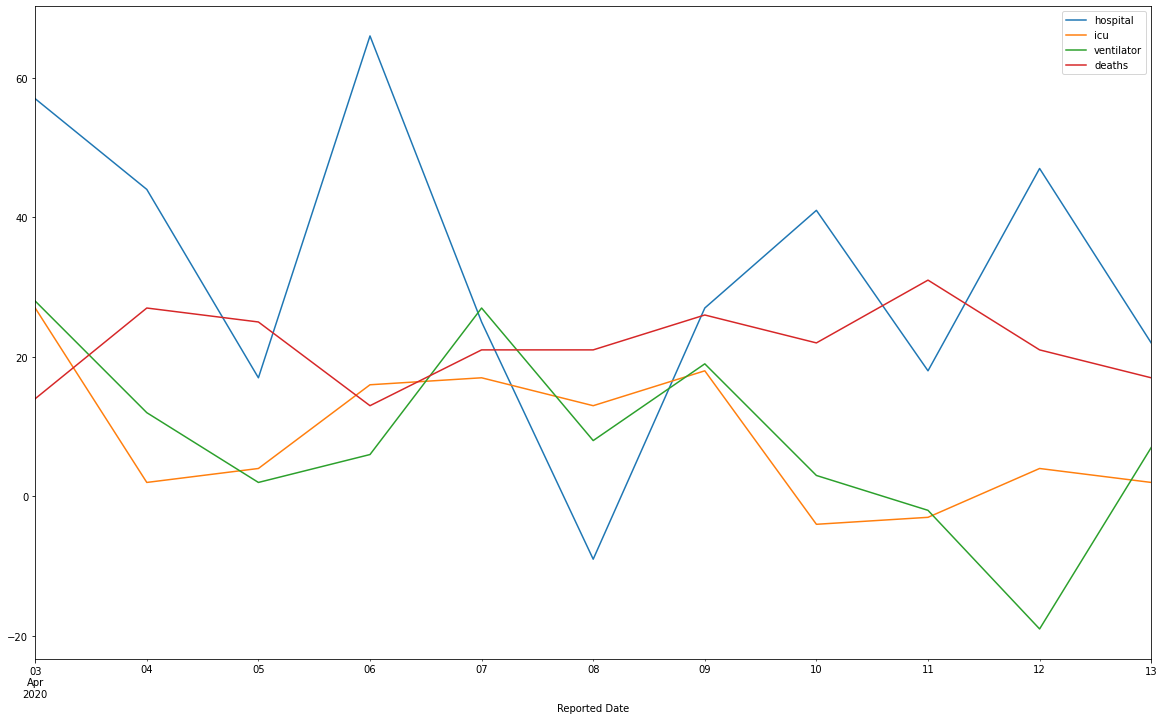

In [23]:
d_morbid[morbid_change.index > pd.to_datetime("2020-04-02")].tail(20).plot()